# Midterm Exam (part 3) - Computational Physics I

### Deadline: Friday 25 October 2024 (by 17h00)
### Name: Vincent Noguera

## Part 3. (12 points) Data analysis and visualisation (Orszag-Tang MHD vortex)

The **Orszag-Tang vortex** system describes a doubly periodic ideal gas configuration leading to 2D supersonic magnetohydrodynamical (MHD) turbulence. Although an analytical solution is not known, its simple and reproducible set of initial conditions has made it very appealing for the comparison of MHD numerical solvers. The computational domain is a **periodic box** with dimensions: $[0,2\pi]^2$, and the gas has an adiabatic index $\gamma=\frac{5}{3}$.

In code units, the initial conditions are given by:

$
\vec{v}_{code} = \left(-\sin y,\, \sin x\right) \,,\qquad
\vec{B}_{code} = \left(-\sin y,\, \sin 2x\right) \,,\qquad
\rho_{code} = 25/9\,,\qquad
p_{code}    = 5/3,
$

and the numerical simulation produces $61$ VTK files stored in:

- the **Orszag-Tang-MHD** folder: 

https://github.com/wbandabarragan/physics-teaching-data/blob/main/2D-data/Orszag_Tang-MHD.zip

which also contains the following descriptor files:

- a **units.out** file that contains the CGS normalisation values.
- a **vtk.out** file whose second column contains the times in code units.
- a **grid.out** file that contains information on the grid structure.

You can use VisIt to inspect the data. The written fields are: 

- density (rho)
- thermal pressure (prs)
- velocity_x (vx1)
- velocity_y (vx2)
- magnetic_field_x (Bx1)
- magnetic_field_y (Bx2)

**Reference paper:**
https://arxiv.org/pdf/1001.2832.pdf

"High-order conservative finite difference GLM-MHD schemes for cell-centered MHD", Mignone, Tzeferacos & Bodo, JCP (2010) 229, 5896.

### Tasks:

Within a single python notebook, carry out the following tasks:



#### Import libraries

In [1]:
#Python veresion used 3.9
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import pandas as pd
import scienceplots
import os
import scipy.constants as cte
import glob
from PIL import Image
from IPython import display
from skimage.transform import resize
import scipy.optimize as opt

### (a) Create a python function that reads the **units.out** file, stores the normalisation values for length, velocity, and density, calculates the normalisation values for thermal pressure, magnetic field, and time, and returns them all into tuple objects.

**Note:**
As shown in class, the normalisation values for thermal pressure ($p_0=\rho_0\,v_0^2$), magnetic field ($B_0=\sqrt{4\,\pi\,\rho_0\,v_0^2}$), and time ($t_0=\frac{L_0}{v_0}$) can be derived from the length, velocity, and density values.


In [2]:

def IO_units_out(path):
    """
    Reads normalization values for density, velocity, and length from 'units.out'
    and calculates additional normalization constants for thermal pressure, 
    magnetic field, and time.
    Input:
        path-> Direction from is located the file units.out 
    Output:
        nrho_0->  normalization value for density
        nl_0  ->  normalization value for length
        nv_0  ->  normalization value for velocity
        Calculated:
        nTP_0 -> normalization value for Thermal Pressure
        nB_0  ->  normalization value for Magnetic Field
        nt_0  ->  normalization value for Time
    """
    df_units = pd.read_csv(path + "units.out")

    nrho_0 = np.array(df_units.loc[df_units["variable"] == "rho_0"]["normalisation"])
    nv_0   = np.array(df_units.loc[df_units["variable"] == "v_0"]["normalisation"])
    nl_0   = np.array(df_units.loc[df_units["variable"] == "L_0"]["normalisation"])

    nTP_0 = nrho_0*((nv_0)**2)
    nB_0  = np.sqrt(4*np.pi*nrho_0*(nv_0**2)) 
    nt_0  = nl_0/nv_0

    return nrho_0, nl_0, nv_0, nTP_0, nB_0, nt_0
  
# print(df_units)

### (b) Create a python function that reads the **vtk.out** file, reads the second column, and returns the times in CGS units using $t_0$ from point (a).


In [3]:
def IO_vtk_out(fname, t0):
    """
    Input:
        path -> Direction from is located the file vtk.out 
        
    Aditional data:
        t_cu-> time in code units
    Output:
        t_cgs -> time in cgs units
    """
    #As the vtk.out object has columns separated by spaces:
    df_vtk_out = pd.read_csv(fname + "vtk.out", sep = "\s+", header = None)

    t_cu  = np.array(df_vtk_out.loc[:,1])
    t_cgs = np.array(t_cu*t0)
    return t_cgs

###  (c) Create a python function that reads a VTK data file, normalises the data fields to CGS units using the values from points (a) and (b), and returns them jointly with the mesh and time information as tuple objects.

(dx2) Call all the above functions for VTK file # 30 of each simulation, and make the following maps using the correct mesh coordinates, dimensions and time, all in in CGS units:

- A figure showing the gas density, $\rho$.

- A figure showing the gas sound speed, $c_s=\sqrt{\gamma\frac{p}{\rho}}$.

- A figure showing showing the kinetic energy density, $E_k = \frac{1}{2}\rho\,v^2$ with $v=\sqrt{v_x^2+v_y^2}$.

- A figure showing the magnetic vector field, $\vec{B}= \vec{B}_x + \vec{B}_y$.

**Notes:** Choose different perceptually-uniform colour schemes for each of the above quantities, and fix the colour bar limits. Add the correct time stamp in CGS units to each map. Since these are high-resolution models, one way to improve the visualisation of 2D vector fields is to interpolate them into a coarser grid.


In [4]:
fname="/home/klaus/CP1/MT/Orszag_Tang-MHD/"
# Read units.out file

# df_units = pv.read(fname + "data.0000.vtk")

# print(df_units.array_names)
# # df_units = pd.read_csv(fname + "units.out")

# df_vtk_out = pd.read_csv(fname + "vtk.out", sep = "\s+", header = None)

# print(df_units)

In [5]:
#
def read_VTK(path,t_cgs, constants,B_shape_2D_resize):
    """
    Input:
        path -> the path of the file 
        constants -> the constants need are:
            nrho_0->  normalization value for density
            nl_0  ->  normalization value for length
            nv_0  ->  normalization value for velocity
            nTP_0 -> normalization value for Thermal Pressure
            nB_0  ->  normalization value for Magnetic Field
            nt_0  ->  normalization value for Time_resize
        B_shape_2D_resize
    Output:
        mesh_from_vtk
        cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]    
            t_cgs -> cgs value for time
            rho_cgs->  cgs value for density
            vx1_cgs  ->  cgs value for velocity 1
            vx2_cgs  ->  cgs value for velocity 2
            Bx1_cgs -> cgs value for Magnetic Field 1
            Bx2_cgs  ->  cgs value for Magnetic Field 2
            prs_cgs -> cgs value for thermal pressure
            
        cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
            rho_cgs2D -> cgs value for density in 2D
            vx1_cgs2D -> cgs value for velocity component 1 in 2D
            vx2_cgs2D -> cgs value for velocity component 2 in 2D
            Bx1_cgs2D -> cgs value for Magnetic Field component 1 in 2D
            Bx2_cgs2D -> cgs value for Magnetic Field component 2 in 2D
            prs_cgs2D -> cgs value for thermal pressure in 2D
            Bx1_cgs2D_resized -> resized cgs value for Magnetic Field component 1 in 2D
            Bx2_cgs2D_resized -> resized cgs value for Magnetic Field component 2 in 2D
    
        grid_2D_array = [x_2d, y_2d]
            x_2d -> 2D array of x-coordinates for the grid
            y_2d -> 2D array of y-coordinates for the grid

        grid_2D_B_array = [x_2d_b, y_2d_b]
            x_2d_b -> 2D array of x-coordinates for the magnetic field grid
            y_2d_b -> 2D array of y-coordinates for the magnetic field grid

        magnitudes = [vel_2d, mag_B_resized, vel, mag_B]
            vel_2d -> 2D array representing velocity magnitudes
            mag_B_resized -> resized magnetic field magnitudes in the 2D grid
            vel -> array representing overall velocity magnitudes
            mag_B -> array representing magnetic field magnitudes

    This function transform to cgs values the data collected from the vtk file
    reshape this data in 2D arrays
    Create grids in physical units based in length and for a magnetic field resized 
    Calculate magnitudes for velocity and magnetic field in 2D and 1D arrays
    """
    # print(path)
    
    nrho_0, nl_0, nv_0, nTP_0, nB_0, nt_0=constants
    mesh_from_vtk = pv.read(path)

    rho = pv.get_array(mesh_from_vtk, "rho", preference = 'cell')
    vx1 = pv.get_array(mesh_from_vtk, "vx1", preference = 'cell')
    vx2 = pv.get_array(mesh_from_vtk, "vx2", preference = 'cell')
    Bx1 = pv.get_array(mesh_from_vtk, "Bx1", preference = 'cell')
    Bx2 = pv.get_array(mesh_from_vtk, "Bx2", preference = 'cell')
    prs = pv.get_array(mesh_from_vtk, "prs", preference = 'cell')
    
    rho_cgs = rho*nrho_0
    
    vx1_cgs = vx1*nv_0
    vx2_cgs = vx2*nv_0
    
    Bx1_cgs = Bx1*nB_0
    Bx2_cgs = Bx2*nB_0

    prs_cgs = prs*nTP_0
    
    nTP_0 = nrho_0*((nv_0)**2)
    nB_0  = np.sqrt(4*np.pi*nrho_0*(nv_0**2)) 
    nt_0  = nl_0/nv_0


    #Reshape into 2D arrays
    
    rho_cgs2D = rho_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    
    vx1_cgs2D = vx1_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    vx2_cgs2D = vx2_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    
    Bx1_cgs2D = Bx1_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    Bx2_cgs2D = Bx2_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)
    prs_cgs2D = prs_cgs.reshape(mesh_from_vtk.dimensions[0] - 1, mesh_from_vtk.dimensions[1] - 1)


    #Create grids:
    #Create the grid in physical units:
    # Create coordinate vectors:
    x = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1],\
                   mesh_from_vtk.dimensions[1] - 1)*nl_0
    y = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3],\
                   mesh_from_vtk.dimensions[0] - 1)*nl_0

    #Create coordinate vector for magnetic field:
    B_shape2D=B_shape_2D_resize
    x_b = np.linspace(mesh_from_vtk.bounds[0], mesh_from_vtk.bounds[1],\
                   B_shape2D)*nl_0
    y_b = np.linspace(mesh_from_vtk.bounds[2], mesh_from_vtk.bounds[3],\
               B_shape2D)*nl_0
    
    #Resize and another grid for magnetic field:
    
    Bx1_cgs2D_resized = resize(Bx1_cgs2D, (B_shape2D,B_shape2D), preserve_range = True, anti_aliasing= True)
    Bx2_cgs2D_resized = resize(Bx2_cgs2D, (B_shape2D,B_shape2D), preserve_range = True, anti_aliasing= True)

    
    # Generate Grid for general
    x_2d, y_2d = np.meshgrid(x, y)
    
    # Generate Grid for magnetic fiel
    x_2d_b, y_2d_b = np.meshgrid(x_b, y_b)

    
    # Calculate the magnitude of B resized
    mag_B_resized = np.sqrt(Bx1_cgs2D_resized**2 + Bx2_cgs2D_resized**2)
    
    # Calculate the magnitude of velocity
    vel_2d = np.sqrt(vx1_cgs2D**2 + vx2_cgs2D**2)
    vel = np.sqrt(vx1_cgs**2 + vx2_cgs**2)
    #Calculate the magnitude of B on cgs
    mag_B_2D = np.sqrt(Bx1_cgs2D**2 + Bx2_cgs2D**2)

    
    #Order arrays to return values:
    cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]

        
    cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
    
    grid_2D_array = [x_2d, y_2d]
    grid_2D_B_array = [x_2d_b, y_2d_b]
    magnitudes = [vel_2d, mag_B_resized, vel, mag_B_2D]
    #mesh_from_vtk,t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs, rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D
    return mesh_from_vtk, cgs_values, cgs_values_2D, grid_2D_array, grid_2D_B_array, magnitudes

In [6]:
constants_normalized=IO_units_out(fname)
# constants_normalized = (nrho_0, nl_0, nv_0, nTP_0, nB_0, nt_0)
#Get time in cgs units:
t_cgs = IO_vtk_out(fname,constants_normalized[5])
#Path in data file #30
path=(fname+"data.0029.vtk")
#Call the function with different arrays acording convinience:
mesh_from_vtk, cgs_values, cgs_values_2D, grid_2D_array, grid_2D_B_array, magnitudes = read_VTK(path,t_cgs, constants_normalized,20)
"""
mesh_from_vtk
cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]    
cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
grid_2D_array = [x_2d, y_2d]
grid_2D_B_array = [x_2d_b, y_2d_b]
magnitudes = [vel_2d, mag_B_resized, vel, mag_B]
"""
#Quantities needed to do the calculus
prs_cgs2D=cgs_values_2D[5]
rho_cgs2D=cgs_values_2D[0]
vel_2d=magnitudes[0]
Bx1_cgs2D_resized = cgs_values_2D[6]
Bx2_cgs2D_resized = cgs_values_2D[7]
Bx1_cgs2D = cgs_values_2D[4]
Bx2_cgs2D = cgs_values_2D[5]
b= magnitudes[3]
b_resized=magnitudes[1]


In [7]:
#Equations:

#Gas sound speed:
gamma=5/3
cs = np.sqrt(gamma*(prs_cgs2D/rho_cgs2D))
print(cs.shape)

#Kinetic energy density
ek = (1/2)*(rho_cgs2D*(vel_2d**2))

#Magnetic vector fiel
# b=Bx1_cgs2D+Bx2_cgs2D

# b_resized=Bx1_cgs2D_resized+Bx2_cgs2D_resized


#To take on count if its necessary log scale:
print(np.min(rho_cgs2D), np.max(rho_cgs2D))
print(np.min(cs), np.max(cs))

print(np.min(ek), np.max(ek))
print(np.min(b_resized), np.max(b_resized))

(256, 256)
1.9998240256309506e-24 9.973545106887817e-24
79723.81436307674 138407.21879029775
3.727026650299816e-19 4.558885292772944e-14
4.518320071031014e-08 1.139948848347557e-06


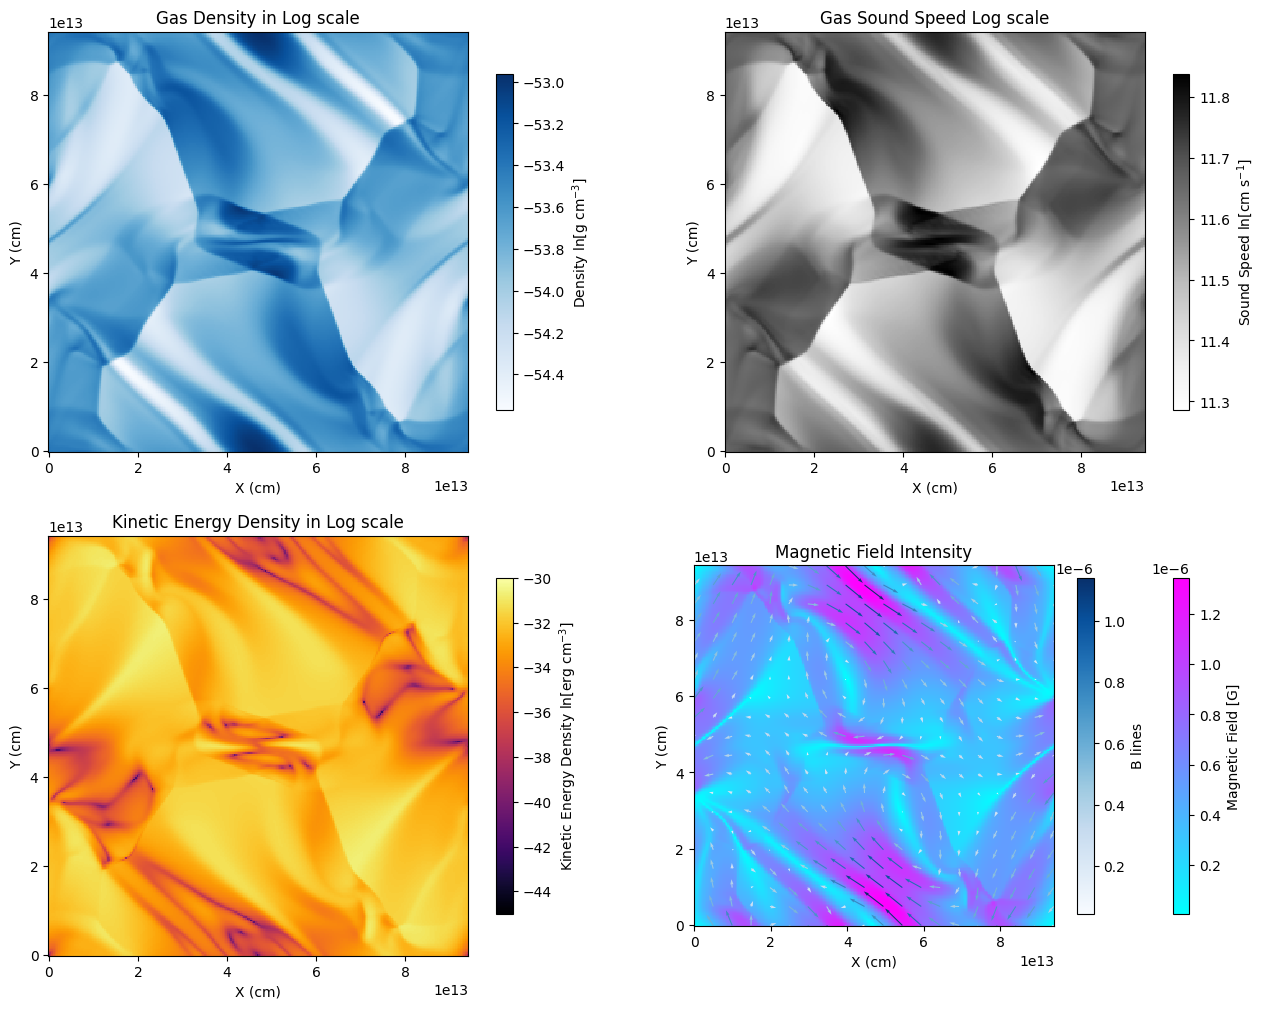

In [8]:
# Plot
plt.figure(figsize=(16,12))

# Plotting the density
plt.subplot(2, 2, 1)
plt.title("Gas Density in Log scale")
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log(rho_cgs2D),  cmap="Blues")
cb = plt.colorbar(z_dens, shrink=0.8)
cb.set_label(r"Density ln[g cm$^{-3}$]")
plt.gca().set_aspect('equal')

# Plotting the gas sound speed
plt.subplot(2, 2, 2)
plt.title("Gas Sound Speed Log scale")
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log(cs), cmap="Grays")
cb = plt.colorbar(z_dens, shrink=0.8)
cb.set_label(r"Sound Speed ln[cm s$^{-1}$]")
plt.gca().set_aspect('equal')


# Plotting the kinetic energy density
plt.subplot(2, 2, 3)
plt.title("Kinetic Energy Density in Log scale")
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log(ek), vmin=-45, vmax=-30, cmap="inferno")
cb = plt.colorbar(z_dens, shrink=0.8)
cb.set_label(r"Kinetic Energy Density ln[erg cm$^{-3}$]")
plt.gca().set_aspect('equal')


# Plotting the magnetic vector field
plt.subplot(2, 2, 4)
plt.title("Magnetic Field Intensity")
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')
#two options:
#made the plot behind as normal
z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], b, cmap="cool")
#Made the plot resizzed, this will loose quality of image
# z_dens = plt.pcolormesh(grid_2D_B_array[0], grid_2D_B_array[1], b_resized, cmap="Purples")
z = plt.quiver(grid_2D_B_array[0], grid_2D_B_array[1], Bx1_cgs2D_resized, Bx2_cgs2D_resized, magnitudes[1], cmap='Blues')
cb = plt.colorbar(z_dens, shrink=0.8)
cb.set_label(r"Magnetic Field [G]")
cb2 = plt.colorbar(z, shrink=0.8)
cb2.set_label(r"B lines")
plt.gca().set_aspect('equal')

plt.show()


### (e) Create a set of Python functions that loops over all the VTK simulation files and returns maps of the density field $\rho$, the kinetic energy density $E_k$, and also histograms of the density field in CGS units for all times, into a folder called "output_data".



In [9]:
# def vtk_simulation(directory_name, num_files, fname):
#     """
#     input:
#         directory_name: name of the directory or folder where we are going to work, if doesn't exist create
#         num_files: number of data files which are going to be analized
#         fname: direction of the folder which contains the vtk files which are going to be analized
        
#     Output:
#         n->  this is a list of arrays with the values of the histograms for each of the arrays in the same order, 
#             from the last histogram to make an analysis
#         bins-> The edges of the bins,  from the last histogram to make an analysis
#     Creates a directory read and process the information in the vtk file to extract physical quantities, 
#     in case that directory exists this will not create another directory,
#     to computes the kinetic energy and the density data, generates and save plot of the density kinetic energy
#     and density in 2D log scale, and create and save an histogram of density values.
#     """
#     # Create the directory
#     try:
#         os.mkdir(directory_name)
#         print(f"Directory '{directory_name}' created successfully.")
#     except FileExistsError:
#         print(f"Directory '{directory_name}' already exists.")
#     except PermissionError:
#         print(f"Permission denied: Unable to create '{directory_name}'.")
#     except Exception as e:
#         print(f"An error occurred: {e}")
#     for i in range(num_files):
#         #Create a folder to save images:
#         #https://www.geeksforgeeks.org/create-a-directory-in-python/
#         # Specify the directory name
        
        
    
        
#         constants_normalized=IO_units_out(fname)
        
#         t_cgs = IO_vtk_out(fname,constants_normalized[-1])
#         # print("time in cgs: ", t_cgs)
#         path = (fname+"data." +"{:04d}".format(i)+".vtk")
#         mesh_from_vtk, cgs_values, cgs_values_2D, grid_2D_array, grid_2D_B_array, magnitudes = read_VTK(path,t_cgs,constants_normalized,50)
#         """
#         mesh_from_vtk
#         cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]    
#         cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
#         grid_2D_array = [x_2d, y_2d]
#         grid_2D_B_array = [x_2d_b, y_2d_b]
#         magnitudes = [vel_2d, mag_B_resized, vel, mag_B]
#         """
    
#         #Quantities needed to do the calculus
#         t_cgs = cgs_values[0]
#         prs_cgs2D = cgs_values_2D[5]
#         rho_cgs2D = cgs_values_2D[0]
#         vel_2d = magnitudes[0]
#         Bx1_cgs2D_resized = cgs_values_2D[6]
#         Bx2_cgs2D_resized = cgs_values_2D[7]
#         rho_cgs = cgs_values[1]
    
        
#         ##Kinetic energy density
#         ek = (1/2)*(rho_cgs2D*(vel_2d**2))

#         #Add exceptions:
#         file_dir_rho2D = f"{directory_name}/density_field_{i:04d}.nps"
#         if not os.path.exists(file_dir_rho2D):
                
#             # Plotting the density
#             with plt.style.context(['science', 'notebook', 'no-latex']):
                
#                 plt.figure(figsize=(6,4))
#                 plt.title(f"Gas Density in log scale, time {t_cgs[i]:.4e}")
#                 plt.xlabel('X (cm)')
#                 plt.ylabel('Y (cm)')
#                 z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log10(rho_cgs2D),vmin=-23, vmax=-23.6,  cmap="Blues")
#                 cb = plt.colorbar(z_dens, shrink=0.8)
#                 cb.set_label(r"Density ln[g cm$^{-3}$]")
            
#                 plt.savefig(f"{directory_name}/density_field_{i:04d}.nps"nps)
#                 # print("dir is:",f"output_data/density_field_{i:05d}.nps")
#                 plt.close()
#         else:
#             print("The file already exist.")
#         # Plotting the kinetic energy density

#         #Add exceptions:
#         file_dir_ke = f"{directory_name}/kinetic_energy_density_field_{i:04d}.nps"
#         if not os.path.exists(file_dir_ke):
             
#             with plt.style.context(['science', 'notebook', 'no-latex']):
                
#                 plt.figure(figsize=(6,4))
#                 plt.title(f"Kinetic Energy Density, time {t_cgs[i]:.4e}")
#                 plt.xlabel('X (cm)')
#                 plt.ylabel('Y (cm)')
#                 z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log(ek), vmin=-45, vmax=-30, cmap="inferno")
#                 cb = plt.colorbar(z_dens, shrink=0.8)
#                 cb.set_label(r"Kinetic Energy Density ln[erg cm$^{-3}$]")
        
#                 plt.savefig(f"{directory_name}/kinetic_energy_density_field_{i:04d}.nps"nps)
#                 # print("dir is:",f"output_data/density_field_{i:05d}.nps")
#                 plt.close()
#         else:
#             print("The file already exist.")
        
#         # Histogram (flatten array)
        
#         #Add exceptions:
#         file_dir_ke = f"{directory_name}/histogram_density_{i:04d}.nps"
#         if not os.path.exists(file_dir_ke):
                 
#             with plt.style.context(['science', 'notebook', 'no-latex']):
             
#                 plt.figure(figsize=(6,4))
                
#                 n, bins, patches = plt.hist(rho_cgs, bins='auto', density = True)#, histtype = "step",, lw = 3.0
#                 plt.title(f"Density Histogram {t_cgs[i]:.4e} ")
#                 plt.xlabel(r"$\rho$")
#                 plt.ylabel(r"N")
#                 plt.ylim(0,1e24)
#                 plt.xlim(0,1e-23)
#                 plt.savefig(f"{directory_name}/histogram_density_{i:04d}.nps"nps)
#                 # plt.show()
#                 plt.close()
#         else:
#             print("The file already exist.")
#             n, bins, patches = plt.hist(rho_cgs, bins='auto', density = True)#, histtype = "step",, lw = 3.0
#             plt.close()
                
#     return n, bins

In [28]:
def vtk_simulation(directory_name, num_files, fname):
    """
    input:
        directory_name: name of the directory or folder where we are going to work, if doesn't exist create
        num_files: number of data files which are going to be analized
        fname: direction of the folder which contains the vtk files which are going to be analized
        
    Output:
        n->  this is a list of arrays with the values of the histograms for each of the arrays in the same order, 
            from the last histogram to make an analysis
        bins-> The edges of the bins,  from the last histogram to make an analysis
    Creates a directory read and process the information in the vtk file to extract physical quantities, 
    in case that directory exists this will not create another directory,
    to computes the kinetic energy and the density data, generates and save plot of the density kinetic energy
    and density in 2D log scale, and create and save an histogram of density values.
    """
    # Create the directory
    try:
        os.mkdir(directory_name)
        print(f"Directory '{directory_name}' created successfully.")
    except FileExistsError:
        print(f"Directory '{directory_name}' already exists.")
    except PermissionError:
        print(f"Permission denied: Unable to create '{directory_name}'.")
    except Exception as e:
        print(f"An error occurred: {e}")
    for i in range(num_files):
        #Create a folder to save images:
        #https://www.geeksforgeeks.org/create-a-directory-in-python/
        # Specify the directory name
        
        
    
        
        constants_normalized=IO_units_out(fname)
        
        t_cgs = IO_vtk_out(fname,constants_normalized[-1])
        # print("time in cgs: ", t_cgs)
        path = (fname+"data." +"{:04d}".format(i)+".vtk")
        mesh_from_vtk, cgs_values, cgs_values_2D, grid_2D_array, grid_2D_B_array, magnitudes = read_VTK(path,t_cgs,constants_normalized,50)
        """
        mesh_from_vtk
        cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]    
        cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
        grid_2D_array = [x_2d, y_2d]
        grid_2D_B_array = [x_2d_b, y_2d_b]
        magnitudes = [vel_2d, mag_B_resized, vel, mag_B]
        """
    
        #Quantities needed to do the calculus
        t_cgs = cgs_values[0]
        prs_cgs2D = cgs_values_2D[5]
        rho_cgs2D = cgs_values_2D[0]
        vel_2d = magnitudes[0]
        Bx1_cgs2D_resized = cgs_values_2D[6]
        Bx2_cgs2D_resized = cgs_values_2D[7]
        rho_cgs = cgs_values[1]
    
        
        ##Kinetic energy density
        ek = (1/2)*(rho_cgs2D*(vel_2d**2))

        #Add exceptions:
        file_dir_rho2D = f"{directory_name}/density_field_{i:04d}.pdf"
        if not os.path.exists(file_dir_rho2D):
                
            # Plotting the density
            with plt.style.context(['science', 'notebook', 'no-latex']):
                
                plt.figure(figsize=(6,4))
                plt.title(f"Gas Density in log scale, time {t_cgs[i]:.4e}")
                plt.xlabel('X (cm)')
                plt.ylabel('Y (cm)')
                z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log10(rho_cgs2D),vmin=-23, vmax=-23.6,  cmap="Blues")
                cb = plt.colorbar(z_dens, shrink=0.8)
                cb.set_label(r"Density ln[g cm$^{-3}$]")
            
                plt.savefig(f"{directory_name}/density_field_{i:04d}.pdf")
                # print("dir is:",f"output_data/density_field_{i:05d}.pdf")
                plt.close()
        else:
            print("The file already exist.")
        # Plotting the kinetic energy density

        #Add exceptions:
        file_dir_ke = f"{directory_name}/kinetic_energy_density_field_{i:04d}.pdf"
        if not os.path.exists(file_dir_ke):
             
            with plt.style.context(['science', 'notebook', 'no-latex']):
                
                plt.figure(figsize=(6,4))
                plt.title(f"Kinetic Energy Density, time {t_cgs[i]:.4e}")
                plt.xlabel('X (cm)')
                plt.ylabel('Y (cm)')
                z_dens = plt.pcolormesh(grid_2D_array[0], grid_2D_array[1], np.log(ek), vmin=-45, vmax=-30, cmap="inferno")
                cb = plt.colorbar(z_dens, shrink=0.8)
                cb.set_label(r"Kinetic Energy Density ln[erg cm$^{-3}$]")
        
                plt.savefig(f"{directory_name}/kinetic_energy_density_field_{i:04d}.pdf")
                # print("dir is:",f"output_data/density_field_{i:05d}.nps")
                plt.close()
        else:
            print("The file already exist.")
        
        # Histogram (flatten array)
        
        #Add exceptions:
        file_dir_ke = f"{directory_name}/histogram_density_{i:04d}.pdf"
        if not os.path.exists(file_dir_ke):
                 
            with plt.style.context(['science', 'notebook', 'no-latex']):
             
                plt.figure(figsize=(6,4))
                
                n, bins, patches = plt.hist(rho_cgs, bins='auto', density = True)#, histtype = "step",, lw = 3.0
                plt.title(f"Density Histogram {t_cgs[i]:.4e} ")
                plt.xlabel(r"$\rho$")
                plt.ylabel(r"N")
                plt.ylim(0,1e24)
                plt.xlim(0,1e-23)
                plt.savefig(f"{directory_name}/histogram_density_{i:04d}.pdf", dpi=150)
                # plt.show()
                plt.close()
        else:
            print("The file already exist.")
            n, bins, patches = plt.hist(rho_cgs, bins='auto', density = True)#, histtype = "step",, lw = 3.0
            plt.close()
                
    return n, bins

In [ ]:
#Define Directory name:
directory_name = "output_data_PARA_JUGAR"
num_files=61
# fname="/home/klaus/CP1/MT/Orszag_Tang-MHD/"
n, bins = vtk_simulation(directory_name, num_files, fname)
print(bins.shape)

Directory 'output_data' already exists.


### (f) Briefly describe: what happens with the density field as time progresses? Does the density field follow any statistical distribution at late times?



In [11]:
# Animation:
# directory_name = "output_data_log"
#File paths
images_input = f"{directory_name}/histogram_density_*.nps"
imgif_output = f"{directory_name}/histogram_density_evolution.gif"

# Collect the images
imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))

img = next(imgs)

img.save(fp = imgif_output, format="GIF", append_images=imgs,\
        save_all=True, duration = 100, loop = 0)
print(f"GIF saved at: {imgif_output}")

GIF saved at: output_data/histogram_density_evolution.gif


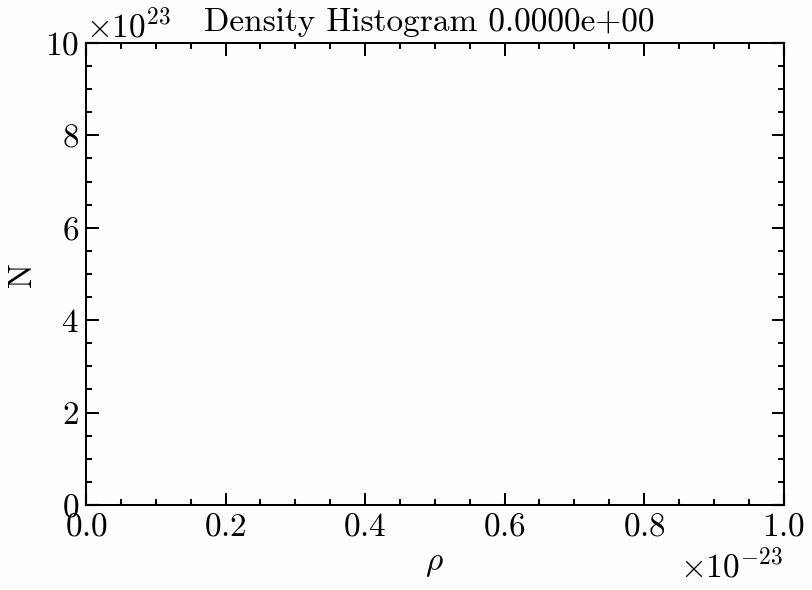

In [12]:

display.Image(open(f'./{directory_name}/histogram_density_evolution.gif','rb').read())

Let's check if corresponds to a log-normal distribution at late times

In [13]:
#Note: to use this code the graphics have to be maded by first tiem, if not n, and bins will not be defined
# Shift arrays:
x0 = 0.5 * ( bins[1:] + bins[:-1] ) 

# Define the model for the fit
def log_normal(x, mu, s):
    """
    Function to define a log-normal distro.
    """
    
    y_model = ((np.exp(-(np.log(x) - mu)**2 / (2*s**2)))/(x * s * np.sqrt(2*np.pi)))
    
    return y_model
# Renormalize the axes

n1 = n/1.e24

x1 = x0/1.e-24
# Fitting:

coef, cova = opt.curve_fit(log_normal, x1, n1)

print(coef)

[1.59444737 0.23897608]


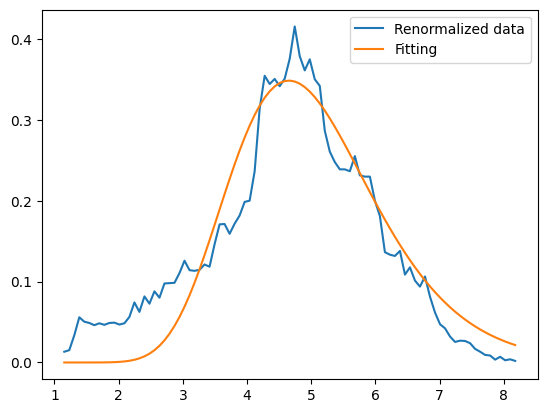

In [14]:
# Evalueta the regression parameters:

n_fit = log_normal(x1, coef[0], coef[1])
# New histogram plot:

plt.figure()

plt.plot(x1, n1, label="Renormalized data")
plt.plot(x1, n_fit, label="Fitting")

plt.legend()
plt.show()

As we can appreciate it's relative similar to a log-normal distribution, and in the gif we can appreciate that starts to oscillate to this form.

### (gx2) Create a set of Python functions that loops over all the VTK simulation files, computes the following quantities in CGS units for each time:

- the average gas temperature, $\overline T$, (**Hint:** the temperature in each grid cell can be calculated using the equation of state for ideal gases, i.e., $p=\frac{\rho k_B\,T}{\mu m_u}$, where $k_B$ is the Boltzmann constant, $m_u$ is the atomic mass unit, and $\mu=0.6$ is the mean particle mass in the gas.)

- the average kinetic energy density, $\overline E_k$, where $E_k = \frac{1}{2}\rho\,v^2$.

- the average magnetic energy density, $\overline E_m$, where $E_m = \frac{1}{2}\frac{B^2}{\,\mu_0}$, where $\mu_0\equiv$ magnetic permeability of free space.

and returns:

- a CSV file with 4 columns, time on the first column, and the above quantities in the next ones. The CSV file should be named "stats.csv" saved into the folder called "output_data".


Let's transform from SI units to CGS units:

$$p=\frac{\rho k_B\,T}{\mu m_u} \rightarrow \, T=\frac{p \mu m_{u}}{\rho k_{B}}$$

$$k_{B}: \left [ \frac{J}{K} \right ] \rightarrow \frac{(kg \cdot m^2)}{(s^2 \cdot K)}=\frac{(1000 \, g) \cdot (100 \, cm)^2}{(s^2 \cdot K)} = \frac{1000 \, g \cdot 10^4 \, cm^2}{s^2 \cdot K} = 10^7 \frac{g \cdot cm^2}{s^2 \cdot K}$$. 

So with these we have to transform the $k_{B}$, using it in SI units is $k_{B}*10^{7}$ to transform to CGS and mantain the units.

In CGS units, the permeability of free space $\mu_0$ is considered equal to 1: 

$$\mu_0 = 1$$. 

For the kinetic energy density keeps the same due to we are working in cgs units both elements.

And for $E_m$ we have to take on count that the value is: $E_m= \frac{B^2}{8\pi}$ 


Source used for magnetic energy density: https://scienceworld.wolfram.com/physics/MagneticFieldEnergyDensity.html

In [15]:
def vtk_quantities(directory_name, num_files, fname, name_new_file):
    """
    input:
        directory_name: name of the directory or folder where we are going to work
        num_files: number of data files which are going to be analized
        fname: direction of the folder which contains the vtk files which are going to be analized 
        name_new_file: what is the name of the csv file that will be created
    Output:
        return 0
    This function will create a csv file which contains: time, avg_temperature, avg_kinetic_energy, avg_magnetic_energy
    in formats of exponentials with 4 decimals for all the data provide base on #number of files and
    """
    #Create a file:
    file = open(f"{directory_name}/{name_new_file}.csv", "w")
    
    # Write a header
    file.write("time,avg_temperature,avg_kinetic_energy,avg_magnetic_energy\n")
    file.close()
    # files_quantity=num_files
    try:
        for i in range(num_files):
            #Call the functions:
            constants_normalized=IO_units_out(fname)
            t_cgs = IO_vtk_out(fname,constants_normalized[-1])
            path = (fname+"data." +"{:04d}".format(i)+".vtk")
            
            mesh_from_vtk, cgs_values, cgs_values_2D, grid_2D_array, grid_2D_B_array, magnitudes = read_VTK(path,t_cgs,constants_normalized,50)
            """
            mesh_from_vtk
            cgs_values = [t_cgs, rho_cgs, vx1_cgs, vx2_cgs, Bx1_cgs, Bx2_cgs, prs_cgs]    
            cgs_values_2D = [rho_cgs2D, vx1_cgs2D, vx2_cgs2D, Bx1_cgs2D, Bx2_cgs2D, prs_cgs2D, Bx1_cgs2D_resized, Bx2_cgs2D_resized]
            grid_2D_array = [x_2d, y_2d]
            grid_2D_B_array = [x_2d_b, y_2d_b]
            magnitudes = [vel_2d, mag_B_resized, vel, mag_B]
            """
            #Quantities required
            prs_cgs = cgs_values[-1]
            rho_cgs = cgs_values[1]
            vel = magnitudes[2]
            mag_B = magnitudes[3]
            #Constants:
            k_b = (cte.k)*(1000*100**2)  #kb [J/K]-> (kg*m^2)/(s^2*K)=1000g*((100cm)**2)/((s))
            mu = 0.6 #the mean particle mass in the gas
            mu_0= 1
            m_u = cte.u*1000 #kg->g
            
            #Formulas:
            #Temperature
            temperature = (prs_cgs*mu*m_u)/(rho_cgs*k_b)
            #Kinetic energy density
            ek = (1/2)*(rho_cgs*(vel**2))
            #magnetic energy density:
            #CGS unit formula= B/(8*pi)
            em=(1/2)*(mag_B**2/(4*np.pi))
            
            #Avg quantities:
            avg_temperature = np.mean(temperature)
            avg_kinetic_energy = np.mean(ek)
            avg_magnetic_energy = np.mean(em)
            
            #Write in the file
            file = open(f"{directory_name}/stats.csv", "a")
            file.write(f"{t_cgs[i]:.4e}, {avg_temperature:.4e}, {avg_kinetic_energy:.4e}, {avg_magnetic_energy:.4e}\n")
            file.close()
            # print(i)
            if i==num_files-1:
                print("Saved")
    except Exception as e:
        print("An error has ocurred")
    return 0

In [16]:
# directory_name = "output_data_log"
num_files=61
name_new_file = "stats"
# fname="/home/klaus/CP1/MT/Orszag_Tang-MHD/"
vtk_quantities(directory_name, num_files, fname,name_new_file)

Saved


0

### (h) Create a Python function that reads in the CSV file created in (g) and returns (i.e. shows or saves) high-quality labeled figures of each of the above-computed quantities versus time, into the folder called "output_data". 



In [17]:
#python func:
def IO_csv(path, directory_name):
    """
    Input:
        path = the direction where we are going to get the information, the csv file.
        directory_name = 
    Output: 
        highquality plots of: 
            Average Gas Temperature Over Time
            Average Kinetic Energy Density Over Time
            Average Magnetic Energy Density Over Time
        This plots will be maded passing point to point, which will be saved, and show the final graphic where i conected all the points

        This could be improved if you ask to the customer what are the base names for the images, using as the parameter 
    """
    
    df=pd.read_csv(path)
    # print(df.head())
    time= np.array(df['time'])
    # avg_kinetic_energy =  np.array(df.iloc[:,2])
    avg_temperature= np.array(df["avg_temperature"])
    avg_kinetic_energy= np.array(df["avg_kinetic_energy"])
    avg_magnetic_energy= np.array(df["avg_magnetic_energy"])
    # avg_magnetic_energy=  np.array(df.iloc[:,3])
    # print(avg_kinetic_energy[0:5])
    
    
    fig_list=[]
    fig_list_temp=[]
    fig_list_ke=[]
    fig_list_b_f=[]
    # print(len(time))
    iter=0
    for i in range(len(time)):
        ##Show the final graphics:
        if i ==len(time)-1:
                # print("Entered")
                with plt.style.context(['science', 'notebook', 'no-latex']):
                    plt_gas_temp = plt.figure(figsize=(4,3))
                
                    z_dens = plt.plot(time[:i], avg_temperature[:i], color='orange',marker = "+") 
                    
                    plt.title(f"Average Gas Temperature Over Time {i:04d}")
                    plt.xlabel("Time [s]")
                    plt.ylabel("Temperature [K]")
                    fig_list_temp.append(plt_gas_temp)
                    plt.ylim(42,56)
                    plt.xlim(0,10e8)p
                    plt.show()
                    plt.close()
        if i ==len(time)-1:
                with plt.style.context(['science', 'notebook', 'no-latex']):
                    plt_kinetic_energ = plt.figure(figsize=(4,3))
                    
                    z_dens = plt.plot(time[:i], avg_kinetic_energy[:i], color='red',marker = "+") 
                    plt.title(f"Average Kinetic Energy Density Over Time {i:04d}")
                    plt.ylim(0,2.5e-14)
                    plt.xlim(0,10e8)
                    plt.xlabel("Time [s]")
                    plt.ylabel("Kinetic Energy [erg/cm³]")
                    # plt.savefig(f"output_data_log/point_avg_kinetic_energy_density_vs_time{i:04d}.nps"nps)
                    fig_list_ke.append(plt_kinetic_energ)
                    plt.show()
                    plt.close()
        
        if i == len(time)-1:
            with plt.style.context(['science', 'notebook', 'no-latex']):
        
                plt_b_energy = plt.figure(figsize=(4,3))
                z_dens = plt.plot(time[:i], avg_magnetic_energy[:i],  color="purple",marker = "+" ) 
                plt.title(f"Average Magnetic Energy Density Over Time {i:04d}")
                plt.ylim(0.8e-14,1.4e-14)
                plt.xlim(0,10e8)
                plt.xlabel("Time [s]")
                plt.ylabel("Magnetic Energy [erg/cm³]")
                # plt.savefig(f"output_data_log/point_avg_magnetic_field_density_vs_time{i:04d}.nps"nps)
                fig_list_b_f.append(plt_b_energy)
                plt.show()
                plt.close()  


                
    #Plotting point by point
        #Plotting the average of temperature  
        #Add exceptions:
        file_dir_temp = f"{directory_name}/point_avg_gas_temp_vs_time{i:04d}.nps"
        if not os.path.exists(file_dir_temp):
            with plt.style.context(['science', 'notebook', 'no-latex']):
                plt_gas_temp = plt.figure(figsize=(4,3))
                
                z_dens = plt.plot(time[:i], avg_temperature[:i], color='orange',marker = "+") 
                
                plt.title(f"Average Gas Temperature Over Time {i:04d}")
                plt.xlabel("Time [s]")
                plt.ylabel("Temperature [K]")
                fig_list_temp.append(plt_gas_temp)
                plt.ylim(42,56)
                plt.xlim(0,10e8)
                plt.savefig(f"{directory_name}/point_avg_gas_temp_vs_time{i:04d}.nps"nps)
                # plt.show()
                plt.close()
        else:
            print(f"The file {directory_name}/point_avg_gas_temp_vs_time{i:04d}.nps already exist.")
      
        #Plotting the kinetic energy density
        #Add exceptions:
        file_dir_ke = f"{directory_name}/point_avg_kinetic_energy_density_vs_time{i:04d}.nps"
        if not os.path.exists(file_dir_ke):
            with plt.style.context(['science', 'notebook', 'no-latex']):
                plt_kinetic_energ = plt.figure(figsize=(4,3))
                
                z_dens = plt.plot(time[:i], avg_kinetic_energy[:i], color='red',marker = "+") 
                plt.title(f"Average Kinetic Energy Density Over Time {i:04d}")
                plt.ylim(0,2.5e-14)
                plt.xlim(0,10e8)
                plt.xlabel("Time [s]")
                plt.ylabel("Kinetic Energy [erg/cm³]")
                plt.savefig(f"{directory_name}/point_avg_kinetic_energy_density_vs_time{i:04d}.nps"nps)
                fig_list_ke.append(plt_kinetic_energ)
                # plt.show()
                plt.close()
        else:
            print(f"The file {directory_name}/point_avg_kinetic_energy_density_vs_time{i:04d}.nps already exist.")
        
                
            
        #Plotting the magnetic vector field
        #Add exceptions:
        file_dir_b_f = f"{directory_name}/point_avg_magnetic_field_density_vs_time{i:04d}.nps"
        if not os.path.exists(file_dir_b_f):
            with plt.style.context(['science', 'notebook', 'no-latex']):
                
                plt_b_energy = plt.figure(figsize=(4,3))
                z_dens = plt.plot(time[:i], avg_magnetic_energy[:i],  color="purple",marker = "+" ) 
                plt.title(f"Average Magnetic Energy Density Over Time {i:04d}")
                plt.ylim(0.8e-14,1.4e-14)
                plt.xlim(0,10e8)
                plt.xlabel("Time [s]")
                plt.ylabel("Magnetic Energy [erg/cm³]")
                plt.savefig(f"{directory_name}/point_avg_magnetic_field_density_vs_time{i:04d}.nps"nps)
                fig_list_b_f.append(plt_b_energy)
                # plt.show()
                plt.close()
        else:
            print(f"The file {directory_name}/point_avg_magnetic_field_density_vs_time{i:04d}.nps already exist.")
        
    
    variables = [time, avg_temperature, avg_kinetic_energy, avg_magnetic_energy]
    return fig_list, variables 

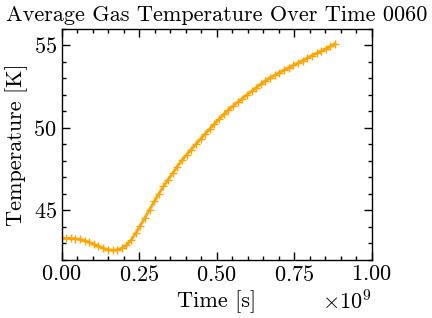

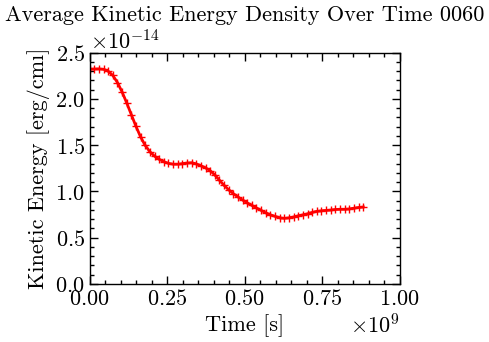

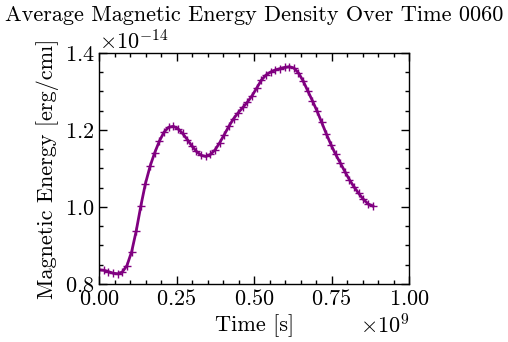

In [18]:
# #use of the function
# path="output_data_log/stats.csv"

path=f"{directory_name}/stats.csv"
figs, variables=IO_csv(path, directory_name)

# variables=IO_csv(path, directory_name)

### (i) Briefly describe: Does the flow reach steady state? Which energy density is dominant?



In [19]:
#extract values required to make a comparison plot
time = variables[0]
avg_kinetic_energy= variables[2]
avg_magnetic_energy = variables[3]

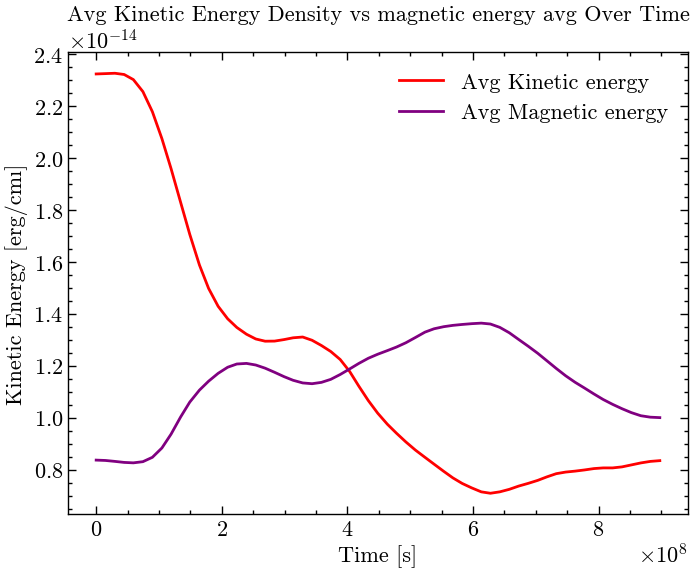

In [22]:

#Plotting the kinetic energy density
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize=(8,6))
    
    plt.plot(time, avg_kinetic_energy, color='red', label= "Avg Kinetic energy")
    plt.plot(time, avg_magnetic_energy,  color="purple",label= "Avg Magnetic energy" ) 
    
    plt.title("Avg Kinetic Energy Density vs magnetic energy avg Over Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Kinetic Energy [erg/cm³]")
    # plt.gca().set_aspect('equal')
    plt.savefig(f"output_data_log/avg_kinetic_energy_density_vs_time.nps"nps)
   
    plt.legend()
    plt.show()
    

We can appreciate that the kinetic energy is dominant until the time is approximately 4e18, after that magnetic energy becomes dominant

### (j) Create a Python function that returns movies showing the time evolution of the kinetic energy density maps computed in (d) and their average values calculated in (g). The movies should be saved into the folder called "output_data". 


In [23]:
#Define the part of the names that shares the images 
base_names=["point_avg_gas_temp_vs_time", "point_avg_kinetic_energy_density_vs_time", "point_avg_magnetic_field_density_vs_time", "kinetic_energy_density_"]
# iter=iter+1
def animation(directory_name, base_name):
    """
    Input:
        directory_name -> refers where is going to be collected the images
                        This could be optimized using a list and a for loop to determine the names of the paths
        base_name -> provide the base name or reference name that will be used for the gif, could be understand for the part that all shares
    Output: 
        Show the direction of the graphics
    About: create gifs 
    """
    for i in range(len(base_name)):
        #File paths
        images_input = f"{directory_name}/{base_name[i]}*.nps"
        imgif_output = f"{directory_name}/GIF_{base_name[i]}.gif"
        
        # Collect the images
        imgs = (Image.open(f) for f in sorted(glob.glob(images_input)))
        
        img = next(imgs)
        
        img.save(fp = imgif_output, format="GIF", append_images=imgs,\
                save_all=True, duration = 100, loop = 0)
        print(f"GIF saved at: {imgif_output}")
animation(directory_name, base_names)

GIF saved at: output_data/GIF_point_avg_gas_temp_vs_time.gif
GIF saved at: output_data/GIF_point_avg_kinetic_energy_density_vs_time.gif
GIF saved at: output_data/GIF_point_avg_magnetic_field_density_vs_time.gif
GIF saved at: output_data/GIF_kinetic_energy_density_.gif


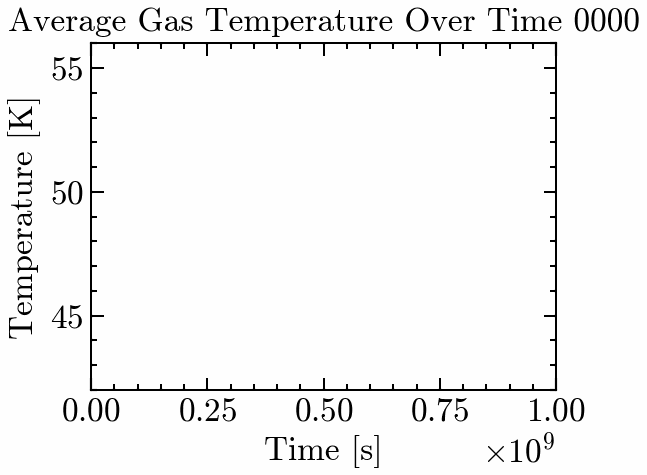

In [24]:
display.Image(open(f'./{directory_name}/GIF_point_avg_gas_temp_vs_time.gif','rb').read())

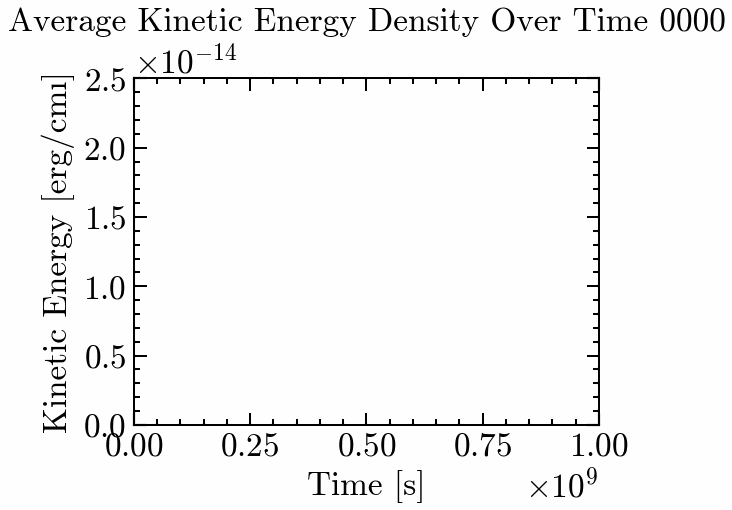

In [25]:

display.Image(open(f'./{directory_name}/GIF_point_avg_kinetic_energy_density_vs_time.gif','rb').read())



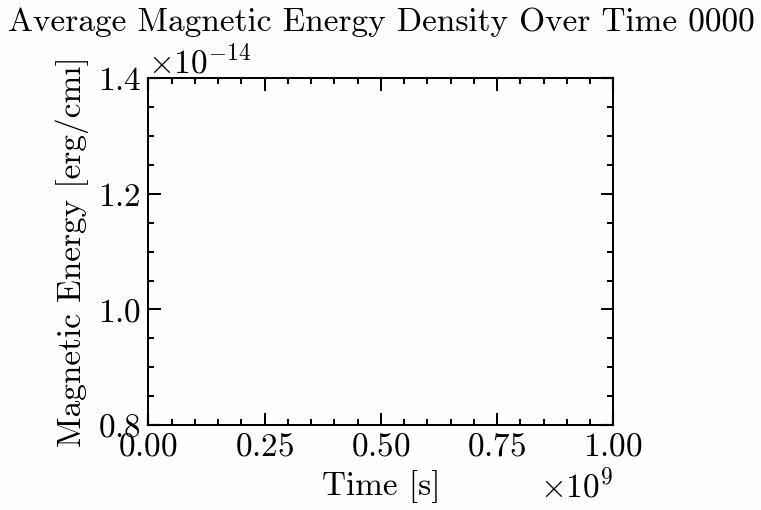

In [26]:

display.Image(open(f'./{directory_name}/GIF_point_avg_magnetic_field_density_vs_time.gif','rb').read())


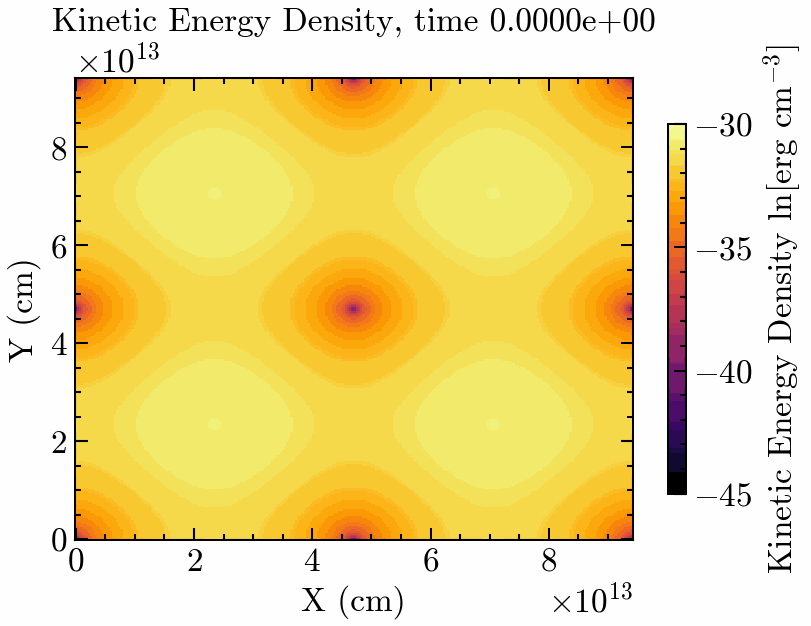

In [27]:

display.Image(open(f'./{directory_name}/GIF_kinetic_energy_density_.gif','rb').read())